# The sign problem<span STYLE="color:blue">$^1$</span>

Monte Carlo methods are usually thought of as numerical integration methods -- to see that the problem of estimating $\pi$ that we solved last lab can be thought of as numerical integration it's helpful to introduce a function $\Theta(z)$ called the ''Heaviside step function'' that is defined to satisfy $\Theta(z \geq 0) = 1$ and $\Theta(z < 0) = 0$. Using the step function, the ratio of areas can be rewritten as a ratio of integrals
$$ \mathcal{P}_{circle} = \frac{ \int_{-r}^r dx \int_{-r}^r dy\  \Theta( 1 - (x^2 + y^2) ) }{  \int_{-r}^r dx \int_{-r}^r dy } $$
To evaluate this ratio, we pick a random sample of $N$ pairs of variables $(x_i,y_i)$ with $i=1,\ldots,N$, where $x_i$ and $y_i$ are drawn from a uniform random distribution for the interval $[-r, r]$, and calculate the integrands in the numerator and denominator at each of these points.
For the $\pi$ lab, the integrand for the denominator is simply equal to 1 for all points, while the integrand for the numerator is equal to 1 for points inside the circle and 0 for other points.
We then approximate each integrals as the sum of the $N$ calculated integrands to get 
$$ \begin{align}
\mathcal{P}_{circle} &= \frac{1}{N} \sum_{i=1}^{N} \Theta( 1 - (x_i^2 + y_i^2) ) + O(N^{-1/2}) \\
&= \frac{N_{circle}}{N}+ O(N^{-1/2}),
\end{align}
$$
where the last line follows because $\Theta( 1 - (x_i^2 + y_i^2) )$ is 1 for random points inside the circle and 0 otherwise.

We could also use a numerical integration routine like SciPy's quad function to do these double integrals. However, numerical integration routines start by breaking up the $x$ domain up into many intervals of width $dx = \delta$ for the $x$ integral and similarly breaking up the $y$ domain into many intervals of width $dy = \delta$ for the $y$ integral. This means that a 2D integral like the one above requires $O(1/\delta^2)$ operations. In general, performing an $D$-dimensional integral numerically with direct methods like quad requires $O(1/\delta^{D})$ operations. To get our final results accurate within a fixed tolerance $\epsilon$ requires $1/\delta < \epsilon$, and therefore the cost of direct integration scales as $O(\epsilon^D)$.  This exponential dependence on the dimensionality of the integrals is sometimes called the ''curse of dimensionality.'' 

On the other hand, Monte Carlo algorithms always have approximation errors proportional to $N^{-1/2}$ even for $D$-dimensional integrals. This means that in order to make our Monte Carlo approximation errors smaller than a fixed value $\epsilon$ only requires $O(\epsilon^2)$ operations instead of $O(\epsilon^D)$. For the case of $D=2$ here, Monte Carlo methods perform similarly to direct numerical integration methods, but simulating physical systems in Quantum Field Theory (quantum mechanics + special relativity) often requires evaluating so-called ''path integrals'' where $D = 10^9$ or bigger. In these cases, Monte Carlo methods are the only practical tool available. We'll learn soon that quantum computers can also use randomness to solve complicated integrals, but they use different algorithms with different strengths and weaknesses.


<span STYLE="color:blue">$^1$Written by Michael Wagman. Last updated 7/12/2021. </span>

The most famous weakness of Monte Carlo algorithms is called the ''__<span STYLE="color:red">sign problem</span>__ .'' The sign problem arises whenever the integrals we're computing have integrands that change sign, or, in other words, whenever the integrands are sometimes positive and sometimes negative. If the integral in the denominator has a sign problem, this is a showstopper: we'd like to interpret the integrand of the denominator as a probability distribution and sample from it, but probability distributions can't be negative so Monte Carlo methods are inapplicable. Even if only the integral in the numerator has a sign problem, this is still really bad: Monte Carlo methods are applicable, but, as we'll see below, the statistical uncertainty of our results increases rapidly as the integrand is taken to include more sign changes. Unfortunately, many interesting quantum systems can only be simulated by solving path integrals with severe sign problems.

The big excitement about using quantum computers to simulate quantum systems is that (at least for some cases) they can avoid both the curse of dimensionality and the sign problem. To see why the sign problem is such a problem, we'll apply the Monte Carlo strategy that we used to estimate $\pi$ to calculate integrals of the form $\cos(n \theta(x,y)) e^{-\theta(x,y)^2}$ where $\theta(x,y)$ is the angle (in radians) of each point $(x,y)$ in polar coordinates. The integer $n$ quantifies how bad the sign problem is -- with $n = 0$ there is no sign problem and we're back to the previous case, while for larger $n$ there are more and more zeros, or ''nodes,'' of $\cos(n \theta(x,y))$, and the sign problem gets worse and worse.

$$ \begin{align} \mathcal{P}(n) &= \frac{ \int_{-r}^r dx \int_{-r}^r dy\  \Theta( 1 - (x^2 + y^2) ) \cos(n \theta(x,y)) e^{-\theta(x,y)^2} }{  \int_{-r}^r dx \int_{-r}^r dy }  \\
&= \frac{1}{N} \sum_{i=1}^{N} \Theta( 1 - (x_i^2 + y_i^2) )\cos(n \theta(x,y))e^{-\theta(x,y)^2}  + O(N^{-1/2}) \end{align}$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def draw_circle_sign(Nsamples, Nsign):

    # create ensemble of random points inside square
    random_vars = np.random.uniform(-1,1, (Nsamples,2))
    
    # variables to store how many random points are inside vs outside the circle
    in_circle = 0
    in_circle_squared = 0

    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_aspect('equal')
    inpoints = []
    inweights = []
    outpoints = []

    for ivar,var in enumerate(random_vars):
        rsq = var[0]**2 + var[1]**2
        theta = np.angle(var[0] + 1j*var[1])
        if rsq < 1:
            weight = np.cos(Nsign*theta)*np.exp(-theta**2)
            inpoints.append(var)
            inweights.append(weight)
            in_circle = in_circle + weight
            in_circle_squared = in_circle_squared + weight**2
        else:
            outpoints.append(var)
        
    color_vec=(1-np.array(inweights))/2
    color_list = [str(c) for c in color_vec]
    
    if len(inpoints)>0:
        ax.scatter(np.array(inpoints)[:, 0], np.array(inpoints)[:, 1],
               color=color_list, s=100/np.sqrt(Nsamples))
    if len(outpoints)>0:
        ax.scatter(np.array(outpoints)[:, 0], np.array(outpoints)[:, 1],
               color="red", s=100/np.sqrt(Nsamples))
            
    plt.show()
    
    print("Weighted sum of points inside circle: ", in_circle)
    
    return in_circle, in_circle_squared

We can visualize these integrals by making the points inside the circle grayscale with black corresponding to points where $\cos(n \theta)e^{-\theta^2} =1$, white corresponding to points where $\cos(n \theta)e^{-\theta^2} =-1$, and shades of gray for everything in between. Let's see what this looks like for $N=10^3$ samples and various numbers of nodes, $n$.

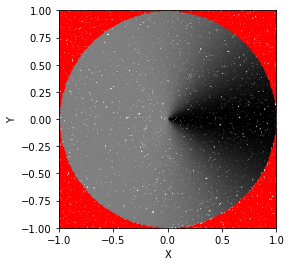

Weighted sum of points inside circle:  22337.284896258585


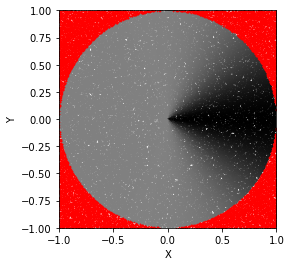

Weighted sum of points inside circle:  17234.803387435157


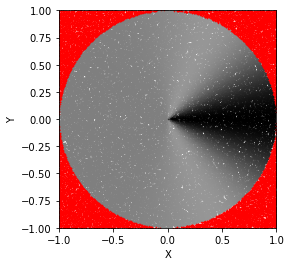

Weighted sum of points inside circle:  8156.124689612023


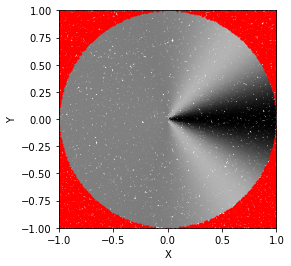

Weighted sum of points inside circle:  2361.8765788941687


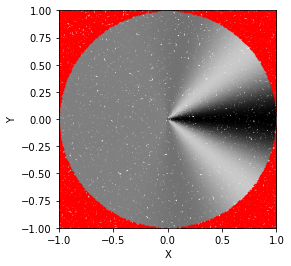

Weighted sum of points inside circle:  294.9359222320576


In [3]:
for n in range(0,5):
    in_circle, in_circle_squared = draw_circle_sign(100000, n)

# Exercises


1. Use the draw_circle_sign function to calculate integrals with $n \in \{0, 1,2,3,4\}$ nodes of  of size $N \in \{10, 10^2, 10^3, 10^4\}$. Make plots of your results vs $N$ for each $n$. Exact results for these integrals and complicated but can be calculated in terms of special functions (the ''error function'' in particular); compare your Monte Carlo results to the exact results function below. The best way to set up your program is to first calculate all your Monte Carlo results and save them to a list or array, and then next write a plotting function that takes the results as input. 


2. Calculate the statistical uncertainty of each Monte Carlo result in step 1 using the standard deviation method of the previous lab. Plot the ''signal-to-noise ratio'' defined as the ratio (result / statistical uncerainty) vs $N$  at each $n$ and verify that (for large $N$) it scales as $O(N^{-1/2})$. Also plot the signal-to-noise ratio vs $n$  at each $N$. Can you guess how the signal-to-noise at fixed $N$ scales with $n$?

In [4]:
# exact integral results for comparison

import scipy as sp
import scipy.special

def exact(n):
    erf1 = sp.special.erf( (1j*n/2 + 2*np.pi)/np.sqrt(2) )
    erf2 = sp.special.erf( (1j*n/2 - 2*np.pi)/np.sqrt(2) ) 
    return 1/16 * np.exp(-n**2/4) * np.sqrt(np.pi) * np.real(erf1 - erf2)